# Проект: Статистический анализ данных.
В качестве аналитика сервиса аренды самокатов GoFast, мне было необходимо проанализировать данные о более 18000 поездках и 1565 пользователях сервиса. Также были доступны сведения о наличии или отсутствии у пользователей ежемесячной подписки и условиях осуществления поездок для обеих групп.
Целью настоящего исследования является проверка некоторых предложенных гипотез, которые могут помочь росту бизнеса. В процессе исследования я планирую осуществить следующие шаги:

1. Открыть файлы с данными, изучить информацию о них.
2. Выявить возможные пропуски и дубликаты и обработать их.
3. Произвести исследовательский анализ данных, чтобы получить больше информации о пользователях и осуществленных ими поездках (частота встречаемости городов, возраст наиболее активных пользователей, соотношение клиентов с подпиской и без подписки, а также продолжительность и расстояние поездок).
4. Объединить данные на основе имеющихся таблиц для упрощения работы с ними, а также произвести разделение пользователей и информации о них на две группы (с подпиской и без) для дальнейшего сравнения двух категорий.
5. Создать агрегированные данные для каждого пользователя о количестве, расстоянии и продолжительности поездок в месяц, а также посчитать принесенную каждым ежемесячную выручку.
6. Проверить предложенные бизнесом гипотезы:
- о большей продолжительности поездок пользователей с подпиской;
- о равенстве среднего расстояния одной поездки пользователей с подпиской 3130 метрам;
- о большей помесячной выручке пользователей с подпиской.
7. Построить графики распределения по заданным условиям:
- количество промокодов, которые необходимо разослать пользователям для продления ежемесячной подписки, чтобы получить как минимум 100 продлений с вероятностью 95%;
- вероятность открытия 1 миллиона разосланных push-уведомлений не более, чем 399,5 тысячами пользователей.

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from scipy.stats import binom

#### Шаг 1. Загрузка данных

Здесь произведена загрузка датасетов и изучена информация о них.

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
display(users.head(10))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
display(rides.head(10))

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
display(subscriptions)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


После первичного анализа данных можно сделать следующие выводы. В работе - три таблицы с различной информацией: первая содержит данные о самих пользователях, включая имя, возраст, город и наличие подписки, в ней 1565 строк. Во втором датафрейме отображены сведения о ежемесячных поездках каждого пользователя по его идентификационному номеру, всего 18068 поездок. Последний содержит информацию об условиях аренды самокатов с подпиской и без. На этапе предобработки необходимо произвести проверку данных на пропуски и дубликаты, а также поменять формат данных в столбце с датой поездки.

#### Шаг 2. Предобработка данных

Преобразование типа данных столбца с датами в формат datetime и добавление столбца с номером месяца, в котором была осуществлена поездка.

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')
display(rides.date.dtype)

dtype('<M8[ns]')

In [10]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
display(rides.head(5))

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверка наличия пропусков в датафреймах.

In [11]:
display(users.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
display(rides.isna().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [13]:
display(subscriptions.isna().sum())

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проверка количества дубликатов и их удаление в первом датафрейме.

In [14]:
duplicates = users.duplicated().sum()
print('Первоначальное количество дубликатов:', duplicates)
users = users.drop_duplicates().reset_index(drop=True)

print('Количество дубликатов после их удаления:', users.duplicated().sum())

Первоначальное количество дубликатов: 31
Количество дубликатов после их удаления: 0


In [15]:
display(rides.duplicated().sum())

0

В загруженных датафреймах не было обнаружено пропусков, что облегчило работу с данными. Дубликаты были найдены только в первой таблице с информацией о пользователях сервиса. В данном случае лучшим решением стало их удаление, так как для анализа не нужны несколько строк с одинаковыми данными для одних и тех же пользователей. 

#### Шаг 3. Исследовательский анализ данных

Визуализация частоты встречаемости городов.

In [16]:
city_info = users.pivot_table(index = 'city', values = 'user_id', aggfunc = 'count').reset_index().rename(columns={'user_id':'count'}).sort_values(by = 'count', ascending = False)
display(city_info.head(10))

,city,count
4,Пятигорск,219
0,Екатеринбург,204
5,Ростов-на-Дону,198
1,Краснодар,193
6,Сочи,189
3,Омск,183
7,Тюмень,180
2,Москва,168


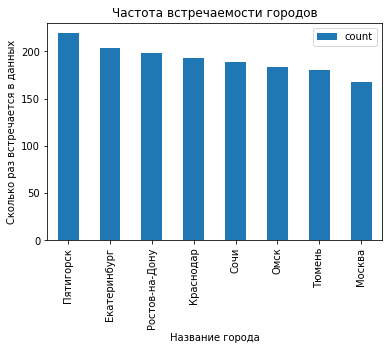

In [17]:
city_info.plot(x = 'city', y = 'count', kind = 'bar', title = 'Частота встречаемости городов', xlabel='Название города', ylabel='Сколько раз встречается в данных')
plt.show()

Чаще всего поездки производились в Пятигорске, реже других городов - в Москве.

In [18]:
#соотношение пользователей с подпиской и без подписки
subscription_rate = users.pivot_table(index = 'subscription_type', values = 'user_id', aggfunc = 'count').reset_index().rename(columns={'user_id':'count'})
subscription_rate['share'] = subscription_rate['count'] / (subscription_rate.loc[0, 'count'] + subscription_rate.loc[1, 'count'])
display(subscription_rate)

,subscription_type,count,share
0,free,835,0.544329
1,ultra,699,0.455671


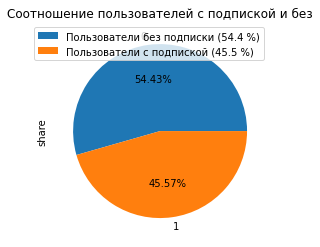

In [19]:
subscription_rate['share'].plot(kind='pie', autopct='%1.2f%%')
labels = [r'Пользователи без подписки (54.4 %)', r'Пользователи с подпиской (45.5 %)']
plt.legend(labels, loc='upper right')
plt.title('Соотношение пользователей с подпиской и без')
plt.show()

У сервиса сравнимое количество пользователей с подпиской и без с небольшим перевесом в пользу второй категории.

In [21]:
# возраст пользователей
users_age = users.pivot_table(index = 'age', values = 'user_id', aggfunc = 'count').reset_index().rename(columns={'user_id':'count'}).sort_values(by = 'age', ascending = False).reset_index(drop=True)
display(users_age)

,age,count
0,43,1
1,39,1
2,38,3
3,37,2
4,36,6
5,35,15
6,34,19
7,33,39
8,32,41
9,31,48


count    29.000000
mean     26.103448
std       8.706914
min      12.000000
25%      19.000000
50%      26.000000
75%      33.000000
max      43.000000
Name: age, dtype: float64

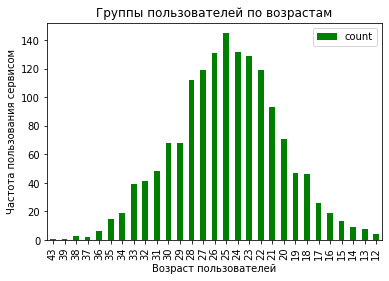

In [22]:
users_age.plot(x = 'age', y = 'count', kind = 'bar', color = 'g', title = 'Группы пользователей по возрастам', xlabel='Возраст пользователей', ylabel='Частота пользования сервисом')
display(users_age['age'].describe())

Кажется логичным, что пик пользования сервиса аренды самокатов приходится на пользователей от 20 до 30 лет с плавным снижением активности в обе стороны (с 12 до 20 и с 30 до 43). Средний возраст пользователей, как видно из описания данных, 26 лет и 75% находятся в диапазоне до 33 лет.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

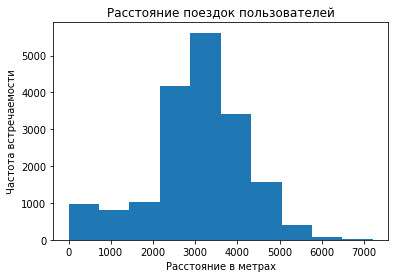

In [23]:
#Расстояние, которое пользователь преодолел за одну поездку
display(rides['distance'].describe())
ax = rides['distance'].plot(kind='hist')
ax.set_xlabel('Расстояние в метрах')
ax.set_ylabel('Частота встречаемости')
plt.title('Расстояние поездок пользователей')
plt.show()

Чаще всего пользователи преодолевали расстояние около 2900 - 3700 метров. Также можно сделать вывод, что короткие поездки (до 5 км) более популярны среди клиентов.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

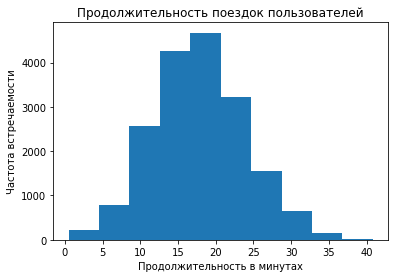

In [24]:
#продолжительность поездок
display(rides['duration'].describe())
ax1 = rides['duration'].plot(kind='hist')
ax1.set_xlabel('Продолжительность в минутах')
ax1.set_ylabel('Частота встречаемости')
plt.title('Продолжительность поездок пользователей')
plt.show()

Как видно на графике, наиболее популярны поездки примерно от 13 до 22 минут, количество поездок, менее и более продолжительных по времени, плавно снижается по мере удаления от среднего значения.

На этапе исследовательского анализа данных были выявлены некоторые закономерности и произведены визуализации:
1. Частота встречаемости разных городов среди клиентов сервиса: от Пятигорска на первом месте и Москвы на последнем.
2. Наиболее активные пользователи аренды самокатов по возрастам: ожидаемо это диапазон 20-30 лет со средним значением 26.
3. Доля пользователей сервиса с подпиской и без: количество последних немного выше.
4. Средние дистанция и продолжительность большинства поездок составляют 3 км и 18 минут соответственно, менее и более продолжительные поездки встречаются реже.

#### Шаг 4. Объединение данных

In [25]:
full_data = users.merge(rides, on = 'user_id')
display(full_data.head(20))
display(full_data.shape[0])

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


18068

In [26]:
full_data = full_data.merge(subscriptions, on = 'subscription_type')
display(full_data.head(10))
display(full_data.shape[0])

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


18068

Получился один датафрейм с данными обо всех поездках пользователей. Далее произведем разделение по двум категориям: пользователи с подпиской и без.

In [27]:
#Пользователи без подписки
full_data_free = full_data.query('subscription_type == "free"')
display(full_data_free.head(10))
display(full_data_free.shape[0])

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


11568

In [28]:
#Пользователи с подпиской
full_data_ultra = full_data.query('subscription_type == "ultra"')
display(full_data_ultra.head(10))
display(full_data_ultra.shape[0])

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


6500

На этом шаге данные были объединены в один датафрейм, а потом разделены на две группы в соответствии с наличием или отсутствием у пользователей подписки. В общей итоговой таблице количество строк сопадает с изначальным - 18068.

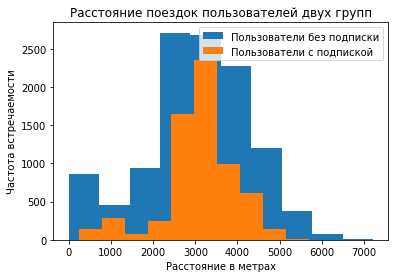

In [29]:
#Дистанция
ax2 = full_data_free['distance'].plot(kind='hist')
ax2 = full_data_ultra['distance'].plot(kind='hist')
ax2.set_xlabel('Расстояние в метрах')
ax2.set_ylabel('Частота встречаемости')
plt.title('Расстояние поездок пользователей двух групп')
labels1 = [r'Пользователи без подписки', r'Пользователи с подпиской']
plt.legend(labels1, loc='upper right')
plt.show()


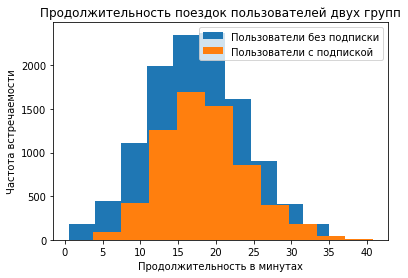

In [30]:
#Визуализация продолжительности
ax3 = full_data_free['duration'].plot(kind='hist')
ax3 = full_data_ultra['duration'].plot(kind='hist')
ax3.set_xlabel('Продолжительность в минутах')
ax3.set_ylabel('Частота встречаемости')
plt.title('Продолжительность поездок пользователей двух групп')
labels1 = [r'Пользователи без подписки', r'Пользователи с подпиской']
plt.legend(labels1, loc='upper right')
plt.show()

На этапе объединения данных была произведена агрегация всех датафреймов с информацией о пользователях сервиса и их поездках, а также созданы две новых таблицы для разных групп пользователей. В дальнейшем на основе созданных таблиц будут произведены необходимые расчеты для проверки гипотез.
Также были визуализированы сравнительные данные двух групп пользователей о продолжительности и дистанции их поездок. Можно отметить тот факт, что наиболее частое расстояние поездок у пользователей с подпиской выше этого же показателя у пользователей из другой группы. По продолжительности поездки обеих групп пользователей похожи, но диапазон значений у пользователей без подписки больше.

#### Шаг 5. Подсчёт выручки

Целью этого шага является подсчет помесячной выручки, которую принес каждый пользователь сервиса.

In [31]:
rides['duration'] = np.ceil(rides['duration'])
display(rides.head(10))

,user_id,distance,duration,date,month
0,1,4409.919140,26.0,2021-01-01,1
1,1,2617.592153,16.0,2021-01-18,1
2,1,754.159807,7.0,2021-04-20,4
3,1,2694.783254,19.0,2021-08-11,8
4,1,4028.687306,27.0,2021-08-28,8
5,1,2770.890808,17.0,2021-10-09,10
6,1,3039.020292,15.0,2021-10-19,10
7,1,2842.118050,24.0,2021-11-06,11
8,1,3412.690668,16.0,2021-11-14,11
9,1,748.690645,16.0,2021-11-22,11


In [33]:
#Создаем таблицу с агрегированными данными о поездках пользователей
users_rides = full_data.pivot_table(index = ['user_id','month', 'subscription_type'], values = ['distance', 'duration'], aggfunc = ['sum', 'count']).reset_index()
users_rides.columns = ['user_id', 'month', 'subscription_type', 'total_distance', 'total_duration', 'total_rides', 'total_rides2']
users_rides = users_rides.drop('total_rides2', axis = 1)
users_rides['total_duration'] = np.ceil(users_rides['total_duration'])
display(users_rides.tail(10))

,user_id,month,subscription_type,total_distance,total_duration,total_rides
11321,1533,8,free,4581.943632,22.0,1
11322,1533,11,free,3414.448028,26.0,1
11323,1534,1,free,4678.415899,16.0,1
11324,1534,2,free,2103.914120,14.0,1
11325,1534,4,free,3434.290912,15.0,1
11326,1534,6,free,3409.468534,26.0,2
11327,1534,8,free,7622.453034,48.0,2
11328,1534,9,free,4928.173852,23.0,1
11329,1534,11,free,13350.015305,78.0,4
11330,1534,12,free,2371.711192,16.0,1


In [34]:
#подсчет выручки
users_rides['minute_price'] = np.where(users_rides.subscription_type == 'ultra', 6, 8)
users_rides['start_ride_price'] = np.where(users_rides.subscription_type == 'ultra', 0, 50)
users_rides['subscription_fee'] = np.where(users_rides.subscription_type == 'ultra', 199, 0)
users_rides['revenue'] = users_rides['start_ride_price'] * users_rides['total_rides'] + users_rides['minute_price'] * users_rides['total_duration'] + users_rides['subscription_fee']
display(users_rides.tail(10))

,user_id,month,subscription_type,total_distance,total_duration,total_rides,minute_price,start_ride_price,subscription_fee,revenue
11321,1533,8,free,4581.943632,22.0,1,8,50,0,226.0
11322,1533,11,free,3414.448028,26.0,1,8,50,0,258.0
11323,1534,1,free,4678.415899,16.0,1,8,50,0,178.0
11324,1534,2,free,2103.914120,14.0,1,8,50,0,162.0
11325,1534,4,free,3434.290912,15.0,1,8,50,0,170.0
11326,1534,6,free,3409.468534,26.0,2,8,50,0,308.0
11327,1534,8,free,7622.453034,48.0,2,8,50,0,484.0
11328,1534,9,free,4928.173852,23.0,1,8,50,0,234.0
11329,1534,11,free,13350.015305,78.0,4,8,50,0,824.0
11330,1534,12,free,2371.711192,16.0,1,8,50,0,178.0


#### Шаг 6. Проверка гипотез

Нулевая гипотеза: Средняя продолжительность поездок пользователей с подпиской равна тому же показателю у пользователей из другой группы.
Альтернативная гипотеза: Средняя продолжительность поездок пользователей с подпиской выше.

H0: µ1 = µ2
H1: µ1 > µ2

In [35]:
#тратят ли пользователи с подпиской больше времени на поездки
print(np.mean(full_data_ultra['duration']))
print(np.mean(full_data_free['duration']))
alpha = 0.05
results = st.ttest_ind(full_data_ultra['duration'], full_data_free['duration'], alternative = 'greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


18.54198516280583
17.39090929866399
p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Благодаря произведенному анализу, мы можем отвергнуть гипотезу о том, что средняя продолжительность поездки пользователей с подпиской такая же, как у другой группы без подписки, в пользу альтернативной гипотезы о том, что этот показатель выше для тех, у кого есть подписка.

Нулевая гипотеза: Среднее расстояние поездок пользователей с подпиской равно 3130 метрам.
Альтернативная гипотеза: Пользователи с подпиской в среднем проезжают больше 3130 метров.

H0: µ1 = 3130
H1: µ1 > 3130

In [36]:
#среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
alpha = 0.05
value = 3130
results = st.ttest_1samp(full_data_ultra['distance'], value, alternative='greater')
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Мы не отвергаем нулевую гипотезу о том, что среднее расстояние, которые проезжают пользователи с подпиской, равно 3130 метрам.

Нулевая гипотеза: Помесячная выручка от пользователей с подпиской такая же, как от другой группы пользователей. Альтернативная гипотеза: Пользователи с подпиской приносят больше выручки по месяцам.

H0: µ1 = µ2 H1: µ1 > µ2

In [37]:
#помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
users_rides_ultra = users_rides[users_rides['subscription_type'] == 'ultra']
users_rides_free = users_rides[users_rides['subscription_type'] == 'free']
alpha = 0.05
results = st.ttest_ind(users_rides_ultra['revenue'], users_rides_free['revenue'], alternative = 'greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу о том, что выручка от пользователей с подпиской и без одинакова.

Вопрос из пункта 6.4: Какой тест понадобится для проверки гипотезы о том, что после обновления сервера взаимодествия с мобильным приложением количество обращений в техподдержку снизилось?
Ответ: для проверки данной гипотезы потребовался бы тест на равенство средних для зависимых (парных) выборок с информацией об одних и тех же пользователях до обновления и после. Для этого можно применить метод Python scipy.stats.ttest_rel(), передав ему в качестве аргументов наборы данных до и после. С его помощью можно будет проверить правосторонную гипотезу о том, что истинное среднее генеральной совокупности до изменения превышает то же самое значение после изменений.

#### Шаг 7. Распределения

<BarContainer object of 101 artists>

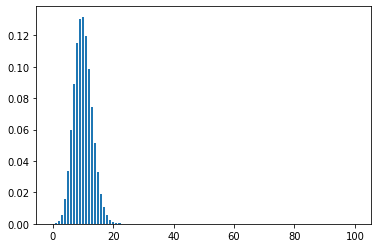

In [38]:
#Построить график распределения вероятности

n = 100
p = 0.1

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)



Как видно на графике, при 100 попытках эксперимента с вероятностью успеха 10% график оказывается сдвинут влево, то есть наиболее вероятно получить до 20 успешных результатов. 

<BarContainer object of 101 artists>

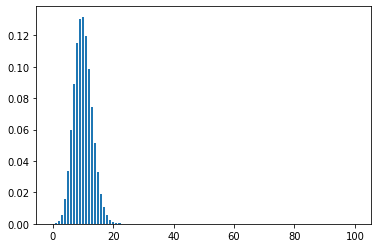

In [39]:
#Построить график распределения вероятности

n = 100
p = 0.1

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)



In [40]:
#Определить количество попыток, необходимое для продления подписки 100 пользователями с вероятностью 95%

n1 = 1170
p = 0.1
k = 100
print(binom.cdf(k,n1,p))

0.05151491673741622


Благодаря встроенной функции можно сделать вывод, что количество отправок промокодов для такого процента продления должно быть примерно 1170, чтобы 100 пользователей осуществили продление подписки с вероятностью примерно 95%

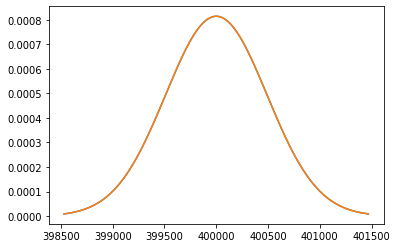

In [41]:
#Вероятность, что не более 399,5 тыс. пользователей из 1 млн откроют уведомление (процент успеха 40%)
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения и аппроксимируем его нормальным
n = 1000000
p = 0.4

left = int(n * p - 3 * sqrt(n * p * (1 - p)))
right = int(n * p + 3 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right))

ax = plt.subplot()

ax.plot(x, binom.pmf(x, n, p))

mu = n * p
sigma = sqrt(n * p * (1 - p))

x = linspace(left, right, 100)

ax.plot(x, norm.pdf(x, mu, sigma))
plt.show()


На графике видно, что большинство значений сосредоточено около 400000 пользователей.

In [42]:
distr = st.norm(mu, sigma)

result = distr.cdf(399500)
print(result)

0.15371708296369768


Выявленная вероятность того, что уведомление откроют не более 399.5 тысяч пользователей из миллиона разосланных, составляет около 15%.

# Общий вывод

В процессе проведения исследования были осуществлены запланированные в начале шаги:
- Изучение информации о данных;
- Предобработка данных (работа с пропусками и дубликатами, изменение формата для некоторых данных);
- Исследовательский анализ данных (о наиболее часто встречаемых значениях среди городов, возраста, продолжительности и расстоянии поездок пользователей);
- Агрегирование данных о пользователях и разделение их на две группы с подпиской/без для дальнейшей визуализации их различий и более подробного изучения информации о них;
- Проверка предложенных гипотез;
- Построение распределений вероятности для возможного осуществления бизнесом некоторых шагов для его развития.

Основные выводы, которые были сделаны на этапе проверки гипотез:
1. Отвергнута гипотеза о том, что средняя продолжительность поездки пользователей с подпиской такая же, как у группы без подписки, в пользу альтернативной гипотезы о том, что этот показатель выше для тех, у кого есть подписка.
2. Не получилось отвергнуть гипотезу о том, что среднее расстояние, которые проезжают пользователи с подпиской, не превышает 3130 метров.
3. Отвергнута гипотеза о том, что выручка от пользователей с подпиской и без одинакова, в пользу альтернативной гипотезы, что клиенты с подпиской приносят больше выручки сервису.